In [221]:
# All imports
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [237]:
# Start price of the simulation!
start_price = 100


# Stockdays per year
days_per_year = 252


# Total number of simulations
n_simul = 5

# Simulation years
sim_years = 5

# Runtime in days
runtime = days_per_year * sim_years - 1

# Withdrawal rate is yearly and after the first year!
yearly_withdrawels = True # If false, then monthly withdrawals
withdraw_after_first_year = True # If false, withdrawal starts with the simulation


# Money is taken out of the account after one year
withdrawel_rate = 0.2

In [223]:
# Find the mean daily Return of NDX and it's standard deviation
ndx_df = yf.download("NDX", auto_adjust=False)

# Log is used to normalize the daily returns
ndx_returns = np.log(1 + ndx_df['Adj Close'].pct_change())

ndx_mu, ndx_sigma = ndx_returns.mean(), ndx_returns.std()

[*********************100%***********************]  1 of 1 completed


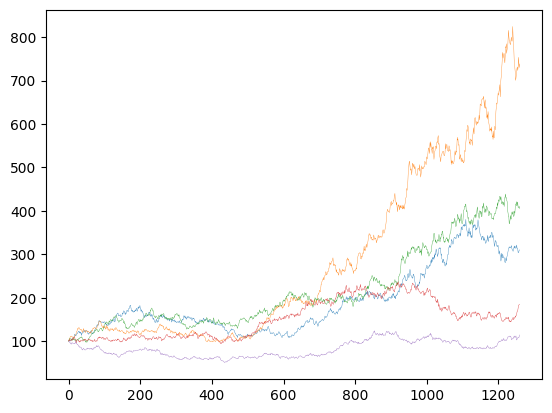

In [224]:
def brown_motion_drift(start_price, mu, sigma, runtime, n_simul):
    sim_returns = np.random.normal(mu, sigma, 
                                size=(runtime, n_simul))

    stacked_returns = np.vstack([np.zeros(n_simul), sim_returns]) # prepends 1 infront of all returns
    sim_prices = start_price * (stacked_returns + 1).cumprod(axis=0)
    return sim_prices

sim_prices = brown_motion_drift(start_price, ndx_mu, ndx_sigma, runtime, n_simul)


plt.plot(sim_prices, linewidth=0.25)
plt.show()

In [225]:
def withdrawels_per_year(withdrawel_rate, start_price):
    return withdrawel_rate * start_price
    
    
def total_withdrawels(withdrawel_rate, start_price, years_till_bust):
    return withdrawels_per_year(withdrawel_rate, start_price) * years_till_bust
    

In [291]:
def brown_motion_drift_plus_wd(start_price, mu, sigma, 
                               runtime, n_simul, days_per_year,
                               sim_years, yearly_withdrawels,
                               withdraw_after_first_year):
    
    sim_returns = np.random.normal(mu, sigma, 
                                size=(runtime, n_simul))

    stacked_returns = np.vstack([np.zeros(n_simul), sim_returns]) # prepends 1 infront of all returns
    
    sim_prices = start_price * (stacked_returns + 1).cumprod(axis=0)
    

    if withdraw_after_first_year:
        if yearly_withdrawels:
            index_arr = np.arange(0, sim_years)
            index_arr = np.repeat(index_arr, days_per_year)
        else:
            index_arr = np.arange(1, (sim_years-1)*12+1)
            index_arr = np.repeat(index_arr, days_per_year/12)
            index_arr = np.concatenate([np.zeros(days_per_year), index_arr], axis=0)
    else:
        if yearly_withdrawels:
            index_arr = np.arange(1, sim_years+1)
            index_arr = np.repeat(index_arr, days_per_year)
        else:
            index_arr = np.arange(1, (sim_years) * 12 + 1)
            index_arr = np.repeat(index_arr, days_per_year/12)

    
    if yearly_withdrawels:
        withdrawal_returns = - index_arr * start_price * withdrawel_rate
    else:
        withdrawal_returns = - index_arr * start_price * (withdrawel_rate / 12)


    # Same for all simulations
    withdrawal_returns = np.expand_dims(withdrawal_returns, axis=1)
    withdrawal_returns = np.repeat(withdrawal_returns, axis=1, repeats=n_simul)

    
    sim_prices += withdrawal_returns

    print(withdrawal_returns)

    return sim_prices

In [295]:

stock_prices = brown_motion_drift_plus_wd(start_price, ndx_mu, ndx_sigma, 
                                          runtime, n_simul, days_per_year,
                                          sim_years, yearly_withdrawels=False,
                                          withdraw_after_first_year=False)

[[  -1.66666667   -1.66666667   -1.66666667   -1.66666667   -1.66666667]
 [  -1.66666667   -1.66666667   -1.66666667   -1.66666667   -1.66666667]
 [  -1.66666667   -1.66666667   -1.66666667   -1.66666667   -1.66666667]
 ...
 [-100.         -100.         -100.         -100.         -100.        ]
 [-100.         -100.         -100.         -100.         -100.        ]
 [-100.         -100.         -100.         -100.         -100.        ]]


In [212]:
# Notes David:
# In this scenario, Inflation is fixed!
# Next step, when zero, make total return equal to 0 for period after!
# Calculate total withdrawals made during the time!
# Start working on dinamic plot
# Implementation only allows for yearly withdrawals and only a withdrawal after the first year!